In [4]:
import os, json, random, math, pickle,cv2
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.data import AUTOTUNE
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as densenet_preprocess
from skimage.color import rgb2gray

In [3]:
!pip install scikit-image


  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/34/e3/49beb08ebccda3c21e871b607c1cb2f258c3fa0d2f609fed0a5ba741b92d/scikit_image-0.25.2-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for networkx>=3.0 from https://files.pythonhosted.org/packages/eb/8d/776adee7bbf76365fdd7f2552710282c79a4ead5d2a46408c9043a2b70ba/networkx-3.5-py3-none-any.whl.metadata
  Obtaining dependency information for imageio!=2.35.0,>=2.33 from https://files.pythonhosted.org/packages/cb/bd/b394387b598ed84d8d0fa90611a90bee0adc2021820ad5729f7ced74a8e2/imageio-2.37.0-py3-none-any.whl.metadata
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/packages/56/b3/23eec760215910609914dd99aba23ce1c72a3bcbe046ee44f45adf740452/tifffile-2025.8.28-py3-none-any.whl.metadata
  Obtaining dependency information for lazy-loader>=0.4 from https://files.pythonhosted.org/packages/83/60/d497a310bde3f01cb805196ac61b7ad6dc5dcf8


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
try:
    import cv2
except Exception:
    cv2 = None
try:
    from skimage.color import rgb2gray
    from skimage.feature import greycomatrix, greycoprops, local_binary_pattern
except Exception:
    rgb2gray = greycomatrix = greycoprops = local_binary_pattern = None

In [ ]:
# ================== CONFIG ==================
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

TRAIN_DIR = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/train_preprocess"   
VAL_DIR   = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/val_preprocess"   

IMG_SIZE = 224       
BATCH_SIZE = 16
HEAD_EPOCHS = 12     
FT_EPOCHS   = 12      
AUGMENT = False      

OUT_DIR = "outputs_msedensenet"
os.makedirs(OUT_DIR, exist_ok=True)


In [5]:
# ================== DATA ==================
def make_augmenter():
    if not AUGMENT:
        # identity để tránh lỗi Sequential rỗng
        return keras.Sequential([layers.Lambda(lambda x: x, name="identity")], name="augmenter")
    return keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.05),
    ], name="augmenter")

def load_ds_5cls(directory, shuffle):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        class_names=["0","1","2","3","4"],
        color_mode="rgb",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=SEED
    )
    return ds.prefetch(AUTOTUNE)

In [8]:
# ================== HAND-CRAFTED FEATURES ==================
def _rgb_hsv_stats(img_u8):
    # img_u8: HxWx3 uint8
    # RGB mean/std
    means = img_u8.reshape(-1,3).mean(axis=0)
    stds  = img_u8.reshape(-1,3).std(axis=0) + 1e-6
    # HSV
    if cv2 is not None:
        hsv = cv2.cvtColor(img_u8, cv2.COLOR_RGB2HSV)
        means_hsv = hsv.reshape(-1,3).mean(axis=0)
        stds_hsv  = hsv.reshape(-1,3).std(axis=0) + 1e-6
    else:
        # fallback nếu thiếu cv2
        means_hsv = np.zeros(3); stds_hsv = np.zeros(3)
    return np.concatenate([means, stds, means_hsv, stds_hsv], axis=0).astype(np.float32)

def _green_hist(img_u8, bins=16):
    g = img_u8[:,:,1]
    hist, _ = np.histogram(g, bins=bins, range=(0,255), density=True)
    return hist.astype(np.float32)

def _glcm_feats(img_u8, levels=32):
    if greycomatrix is None or greycoprops is None:
        return np.zeros(6, dtype=np.float32)  # contrast, dissimilarity, homogeneity, energy, correlation, ASM
    gray = cv2.cvtColor(img_u8, cv2.COLOR_RGB2GRAY) if cv2 is not None else (rgb2gray(img_u8)*255).astype(np.uint8)
    # quantize to 'levels'
    q = (gray.astype(np.float32) * (levels/256.0)).astype(np.uint8)
    # distances & angles
    dists = [1, 2, 4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = greycomatrix(q, distances=dists, angles=angles, levels=levels, symmetric=True, normed=True)
    feats = []
    for prop in ['contrast','dissimilarity','homogeneity','energy','correlation','ASM']:
        v = greycoprops(glcm, prop)  # shape (len(dists), len(angles))
        feats.append(v.mean())
    return np.array(feats, dtype=np.float32)

def _lbp_hist(img_u8, P=8, R=1.0):
    if local_binary_pattern is None:
        return np.zeros(P+2, dtype=np.float32)
    gray = cv2.cvtColor(img_u8, cv2.COLOR_RGB2GRAY) if cv2 is not None else (rgb2gray(img_u8)*255).astype(np.uint8)
    lbp = local_binary_pattern(gray, P=P, R=R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P+3), range=(0, P+2), density=True)
    return hist.astype(np.float32)  # length P+2

def handcrafted_features_numpy(img_np):
    """
    img_np: float32 (H,W,3) in [0,255] (from tf.dataset), convert to uint8 for features.
    Returns 1D float32 vector.
    """
    if img_np.dtype != np.uint8:
        img_u8 = np.clip(img_np, 0, 255).astype(np.uint8)
    else:
        img_u8 = img_np
    f1 = _rgb_hsv_stats(img_u8)           # 12
    f2 = _green_hist(img_u8, bins=16)     # 16
    f3 = _glcm_feats(img_u8, levels=32)   # 6
    f4 = _lbp_hist(img_u8, P=8, R=1.0)    # 10
    feats = np.concatenate([f1, f2, f3, f4], axis=0)  # total 44
    return feats.astype(np.float32)

# Tính kích thước đặc trưng một lần để set_shape cho tf.data
_FEATURE_DIM = len(handcrafted_features_numpy(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)))

def add_handcrafted_to_batch(x, y):
    """
    x: (B,H,W,3) float32 [0,255] ; y: (B,)
    return: ((x, feats), y)  với feats shape (B, _FEATURE_DIM)
    """
    def _batch_feats(x_batch):
        x_np = x_batch.numpy()  # (B,H,W,3)
        feats = [handcrafted_features_numpy(img) for img in x_np]
        return np.stack(feats, axis=0).astype(np.float32)

    feats = tf.py_function(func=_batch_feats, inp=[x], Tout=tf.float32)
    feats.set_shape([None, _FEATURE_DIM])
    return (x, feats), y

In [20]:
# ================== MODEL ==================
def build_msedensenet_model():
    # Input 1: ảnh
    inp_img = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image_input")
    x = make_augmenter()(inp_img)
    x = layers.Rescaling(1./255)(x)
    base = DenseNet121(include_top=False, weights="imagenet", input_tensor=x, pooling="avg", name="densenet121")
    base.trainable = False
    feat_cnn = base.output                      # (None, 1024)

    # Head CNN nhỏ
    h = layers.Dropout(0.4)(feat_cnn)
    h = layers.Dense(512, activation="relu")(h)
    h = layers.BatchNormalization()(h)
    h = layers.Dropout(0.3)(h)

    # Input 2: đặc trưng thủ công
    inp_feat = layers.Input(shape=(_FEATURE_DIM,), name="handcrafted_input")
    f = layers.BatchNormalization()(inp_feat)
    f = layers.Dense(128, activation="relu")(f)
    f = layers.Dropout(0.3)(f)

    # Hợp nhất
    z = layers.Concatenate()([h, f])
    z = layers.Dense(256, activation="relu")(z)
    z = layers.Dropout(0.3)(z)
    out = layers.Dense(5, activation="softmax", name="pred")(z)

    model = keras.Model([inp_img, inp_feat], out, name="MSE_DenseNet121_Handcrafted")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def unfreeze_backbone(model, n_last=100, lr=1e-4):
   # lấy tất cả layer conv2, conv3, conv4, conv5 bên trong backbone
    backbone_layers = [l for l in model.layers if l.name.startswith(("conv", "pool", "bn", "relu", "avg_pool"))]

    # chỉ mở n_last layer cuối
    for l in backbone_layers[:-n_last]:
        l.trainable = False
    for l in backbone_layers[-n_last:]:
        if isinstance(l, layers.BatchNormalization):
            l.trainable = False
        else:
            l.trainable = True

    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

In [21]:
# ================== EVAL HELPERS ==================
def collect_predictions(model, ds):
    y_true_all, p_all = [], []
    for (x_img, x_feat), y in ds:
        p = model.predict([x_img, x_feat], verbose=0)
        p_all.append(p)
        y_true_all.append(y.numpy())
    return np.concatenate(y_true_all), np.concatenate(p_all, axis=0)

def report_metrics(y_true, p, title="VAL"):
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    y_pred = np.argmax(p, axis=1)
    print(f"\n== {title} ==")
    print("Accuracy:", f"{accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

In [22]:
# ================== MAIN ==================
def main():
    print("== Tạo dataset gốc ==")
    ds_train_raw = load_ds_5cls(TRAIN_DIR, shuffle=True)
    ds_val_raw   = load_ds_5cls(VAL_DIR, shuffle=False)

    # Gắn đặc trưng thủ công vào mỗi batch
    print(f"Feature dim = {_FEATURE_DIM}")
    ds_train = ds_train_raw.map(add_handcrafted_to_batch, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_val   = ds_val_raw.map(add_handcrafted_to_batch,   num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

    # ====== Train head ======
    head_path = os.path.join(OUT_DIR, "head_best.keras")

    if os.path.exists(head_path):
        print("\n=== Load model từ head_best.keras ===")
        model = keras.models.load_model(head_path, compile=False,safe_mode=False)
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
    else:
        print("\n=== Huấn luyện head (freeze backbone) ===")
        model = build_msedensenet_model()
        cbs = [
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
            keras.callbacks.ModelCheckpoint(head_path, monitor="val_loss", save_best_only=True)
        ]
        model.fit(ds_train, validation_data=ds_val, epochs=HEAD_EPOCHS, callbacks=cbs)


    # ====== Fine-tune backbone ======
    print("\n=== Fine-tune DenseNet121 (mở ~100 layer cuối) ===")
    unfreeze_backbone(model, n_last=100, lr=1e-4)
    cbs_ft = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
        keras.callbacks.ModelCheckpoint(os.path.join(OUT_DIR, "finetune_best.keras"), monitor="val_loss", save_best_only=True)
    ]
    model.fit(ds_train, validation_data=ds_val, epochs=FT_EPOCHS, callbacks=cbs_ft)

    # Lưu
    final_path = os.path.join(OUT_DIR, "msedensenet_final.keras")
    model.save(final_path)
    print("Saved:", final_path)

    # Đánh giá nhanh trên VAL
    y_val, p_val = collect_predictions(model, ds_val)
    report_metrics(y_val, p_val, title="VAL (MSE-DenseNet+Handcrafted)")

    with open(os.path.join(OUT_DIR, "summary.json"), "w", encoding="utf-8") as f:
        json.dump({"done": True, "feature_dim": int(_FEATURE_DIM)}, f, ensure_ascii=False, indent=2)


In [23]:
main()

== Tạo dataset gốc ==
Found 7324 files belonging to 5 classes.
Found 366 files belonging to 5 classes.
Feature dim = 44

=== Huấn luyện head (freeze backbone) ===
Epoch 1/12


I0000 00:00:1755395367.668887    9908 service.cc:152] XLA service 0x715490002850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755395367.668921    9908 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-16 21:49:28.164330: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755395370.527086    9908 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/458 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.1458 - loss: 2.3034 

I0000 00:00:1755395388.998801    9908 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4142 - loss: 1.5625

2025-08-16 21:50:33.694542: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16780288 bytes after encountering the first element of size 16780288 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-08-16 21:50:35.987030: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3337_0', 200 bytes spill stores, 416 bytes spill loads

2025-08-16 21:50:36.082078: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3337', 4 bytes spill stores, 4 bytes spill loads

2025-08-16 21:50:36.281023: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm

458/458 ━━━━━━━━━━━━━━━━━━━━ 101s 159ms/step - accuracy: 0.4143 - loss: 1.5621 - val_accuracy: 0.5219 - val_loss: 1.0842 - learning_rate: 0.0010
Epoch 2/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 51s 111ms/step - accuracy: 0.5285 - loss: 1.1494 - val_accuracy: 0.5546 - val_loss: 1.1115 - learning_rate: 0.0010
Epoch 3/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5491 - loss: 1.0822

2025-08-16 21:52:35.482002: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16780288 bytes after encountering the first element of size 16780288 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


458/458 ━━━━━━━━━━━━━━━━━━━━ 44s 95ms/step - accuracy: 0.5491 - loss: 1.0822 - val_accuracy: 0.4672 - val_loss: 1.2699 - learning_rate: 0.0010
Epoch 4/12
  4/458 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.4883 - loss: 1.1224

2025-08-16 21:52:36.785361: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16780288 bytes after encountering the first element of size 16780288 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


458/458 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - accuracy: 0.5480 - loss: 1.0454 - val_accuracy: 0.4672 - val_loss: 1.2973 - learning_rate: 0.0010
Epoch 5/12
  3/458 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.5243 - loss: 1.1403  

2025-08-16 21:53:27.425109: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16780288 bytes after encountering the first element of size 16780288 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


458/458 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - accuracy: 0.5713 - loss: 1.0159 - val_accuracy: 0.4918 - val_loss: 1.1989 - learning_rate: 5.0000e-04
Epoch 6/12
457/458 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5761 - loss: 1.0019

2025-08-16 21:54:43.113141: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16780288 bytes after encountering the first element of size 16780288 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


458/458 ━━━━━━━━━━━━━━━━━━━━ 27s 59ms/step - accuracy: 0.5761 - loss: 1.0018 - val_accuracy: 0.5109 - val_loss: 1.1684 - learning_rate: 5.0000e-04

=== Fine-tune DenseNet121 (mở ~100 layer cuối) ===
Epoch 1/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 77s 118ms/step - accuracy: 0.5287 - loss: 1.1151 - val_accuracy: 0.5410 - val_loss: 1.0006 - learning_rate: 1.0000e-04
Epoch 2/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - accuracy: 0.5731 - loss: 0.9923 - val_accuracy: 0.5410 - val_loss: 0.9963 - learning_rate: 1.0000e-04
Epoch 3/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - accuracy: 0.6136 - loss: 0.9175 - val_accuracy: 0.5519 - val_loss: 1.0307 - learning_rate: 1.0000e-04
Epoch 4/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - accuracy: 0.6428 - loss: 0.8348 - val_accuracy: 0.4317 - val_loss: 1.5497 - learning_rate: 1.0000e-04
Epoch 5/12
  3/458 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.7361 - loss: 0.7051

2025-08-16 21:57:20.624403: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16780288 bytes after encountering the first element of size 16780288 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


458/458 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - accuracy: 0.6836 - loss: 0.7531 - val_accuracy: 0.5273 - val_loss: 1.2494 - learning_rate: 5.0000e-05
Epoch 6/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.7131 - loss: 0.6855 - val_accuracy: 0.5656 - val_loss: 1.2070 - learning_rate: 5.0000e-05
Epoch 7/12
  3/458 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.8021 - loss: 0.6262

2025-08-16 21:58:38.351751: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16780288 bytes after encountering the first element of size 16780288 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


458/458 ━━━━━━━━━━━━━━━━━━━━ 52s 112ms/step - accuracy: 0.7603 - loss: 0.6050 - val_accuracy: 0.5984 - val_loss: 1.1391 - learning_rate: 2.5000e-05
Saved: outputs_msedensenet/msedensenet_final.keras


2025-08-16 21:59:31.244703: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16780288 bytes after encountering the first element of size 16780288 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



== VAL (MSE-DenseNet+Handcrafted) ==
Accuracy: 0.5410
              precision    recall  f1-score   support

           0     0.9459    0.7778    0.8537       180
           1     0.2417    0.7838    0.3694        37
           2     0.6429    0.0900    0.1579       100
           3     0.1912    0.6500    0.2955        20
           4     0.4375    0.2414    0.3111        29

    accuracy                         0.5410       366
   macro avg     0.4918    0.5086    0.3975       366
weighted avg     0.7104    0.5410    0.5411       366

Confusion matrix:
 [[140  39   0   1   0]
 [  5  29   1   1   1]
 [  3  40   9  43   5]
 [  0   2   2  13   3]
 [  0  10   2  10   7]]


2025-08-16 21:59:48.258607: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model_on_test(model_path, test_dir, img_size=224, batch_size=16):
    """
    Đánh giá model trên tập test (chứa thư mục con 0..4).
    """
    # 1) Load model
    model = keras.models.load_model(model_path, compile=False,safe_mode=False)

    # 2) Load test dataset
    ds_test_raw = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        labels="inferred",
        label_mode="int",
        class_names=["0", "1", "2", "3", "4"],
        color_mode="rgb",
        image_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=False  # quan trọng để so sánh nhãn
    )
    ds_test = ds_test_raw.map(add_handcrafted_to_batch, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

    # 3) Dự đoán
    y_true, y_pred, y_prob = [], [], []
    for (x_img, x_feat), y in ds_test:
        p = model.predict([x_img, x_feat], verbose=0)
        y_true.extend(y.numpy())
        y_pred.extend(np.argmax(p, axis=1))
        y_prob.extend(p)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 4) Báo cáo Precision, Recall, F1-score
    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, digits=4))

    # 5) Vẽ Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["0","1","2","3","4"], 
                yticklabels=["0","1","2","3","4"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix on Test Set")
    plt.show()


Found 367 files belonging to 5 classes.


2025-08-16 22:04:06.487999: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3318', 12 bytes spill stores, 12 bytes spill loads

2025-08-16 22:04:06.801521: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3318_0', 184 bytes spill stores, 404 bytes spill loads

2025-08-16 22:04:07.016383: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3318', 112 bytes spill stores, 112 bytes spill loads

2025-08-16 22:04:07.023550: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3318', 8 bytes spill stores, 8 bytes spill loads

2025-08-16 22:04:07.058229: I extern


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9810    0.8564    0.9145       181
           1     0.2903    0.7297    0.4154        37
           2     0.7857    0.1100    0.1930       100
           3     0.1628    0.7368    0.2667        19
           4     0.6875    0.3667    0.4783        30

    accuracy                         0.5940       367
   macro avg     0.5815    0.5599    0.4535       367
weighted avg     0.7918    0.5940    0.5984       367



2025-08-16 22:04:22.599855: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


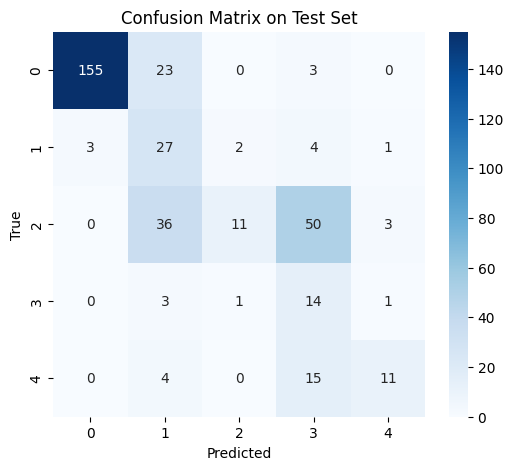

In [27]:
evaluate_model_on_test(
    model_path="outputs_msedensenet/msedensenet_final.keras",
    test_dir="/home/duc/Documents/DoAn/aptos2019-blindness-detection/test_preprocess",
    img_size=224,
    batch_size=16
)

In [1]:
!ipynb-py-convert structure_model_densnet121.ipynb densnet121.py

In [1]:
import os, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.data import AUTOTUNE

# ================== CONFIG ==================
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

TRAIN_DIR = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/train_preprocess"
VAL_DIR   = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/val_preprocess"

IMG_SIZE = 224
BATCH_SIZE = 16
HEAD_EPOCHS = 12
FT_EPOCHS   = 12
OUT_DIR = "outputs_densenet121"
os.makedirs(OUT_DIR, exist_ok=True)


# ================== DATA ==================
def make_augmenter():
    return keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.05),
    ], name="augmenter")

def load_ds(directory, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        class_names=["0","1","2","3","4"],
        color_mode="rgb",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=SEED
    )
    return ds.prefetch(AUTOTUNE)


# ================== MODEL ==================
def build_densenet121_model():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image_input")
    x = make_augmenter()(inp)
    x = layers.Rescaling(1./255)(x)

    base = DenseNet121(include_top=False, weights="imagenet",
                       input_tensor=x, pooling="avg", name="densenet121")
    base.trainable = False

    h = layers.Dropout(0.4)(base.output)
    h = layers.Dense(512, activation="relu")(h)
    h = layers.BatchNormalization()(h)
    h = layers.Dropout(0.3)(h)
    out = layers.Dense(5, activation="softmax", name="pred")(h)

    model = keras.Model(inp, out, name="DenseNet121_only")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


def unfreeze_backbone(model, n_last=100, lr=1e-4):
    """
    Mở n_last layer cuối của backbone DenseNet121 để fine-tune.
    Không phụ thuộc vào tên 'densenet121' nữa, mà lọc các layer conv/pool/bn.
    """
    backbone_layers = [
        l for l in model.layers 
        if l.name.startswith(("conv", "pool", "bn", "relu", "avg_pool"))
    ]

    # Đóng băng hầu hết, chỉ mở n_last layer cuối
    for l in backbone_layers[:-n_last]:
        l.trainable = False
    for l in backbone_layers[-n_last:]:
        if isinstance(l, layers.BatchNormalization):
            l.trainable = False
        else:
            l.trainable = True

    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# ================== MAIN ==================
def main():
    ds_train = load_ds(TRAIN_DIR, shuffle=True)
    ds_val   = load_ds(VAL_DIR, shuffle=False)

    # ====== Train head ======
    model = build_densenet121_model()
    cbs = [
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, min_lr=1e-6),
        keras.callbacks.ModelCheckpoint(os.path.join(OUT_DIR, "head_best.keras"), monitor="val_accuracy", save_best_only=True)
    ]
    model.fit(ds_train, validation_data=ds_val, epochs=HEAD_EPOCHS, callbacks=cbs)

    # ====== Fine-tune backbone ======
    unfreeze_backbone(model, n_last=100, lr=1e-4)
    cbs_ft = [
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-6),
        keras.callbacks.ModelCheckpoint(os.path.join(OUT_DIR, "finetune_best.keras"), monitor="val_accuracy", save_best_only=True)
    ]
    model.fit(ds_train, validation_data=ds_val, epochs=FT_EPOCHS, callbacks=cbs_ft)

    # Lưu
    final_path = os.path.join(OUT_DIR, "densenet121_final.keras")
    model.save(final_path)
    print("Saved:", final_path)


if __name__ == "__main__":
    main()


2025-08-17 10:05:28.964378: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-17 10:05:28.984911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755439529.011229   10454 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755439529.019002   10454 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755439529.037214   10454 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Found 7324 files belonging to 5 classes.


I0000 00:00:1755439532.262638   10454 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2281 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 366 files belonging to 5 classes.
Epoch 1/12


I0000 00:00:1755439546.067193   10572 cuda_dnn.cc:529] Loaded cuDNN version 90300


458/458 ━━━━━━━━━━━━━━━━━━━━ 58s 104ms/step - accuracy: 0.3906 - loss: 1.6549 - val_accuracy: 0.4126 - val_loss: 1.4595 - learning_rate: 0.0010
Epoch 2/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - accuracy: 0.4842 - loss: 1.2617 - val_accuracy: 0.4918 - val_loss: 1.1575 - learning_rate: 0.0010
Epoch 3/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 44s 95ms/step - accuracy: 0.5069 - loss: 1.1908 - val_accuracy: 0.4563 - val_loss: 1.3365 - learning_rate: 0.0010
Epoch 4/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 44s 95ms/step - accuracy: 0.5053 - loss: 1.1675 - val_accuracy: 0.3497 - val_loss: 1.7400 - learning_rate: 0.0010
Epoch 5/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 44s 96ms/step - accuracy: 0.5206 - loss: 1.1433 - val_accuracy: 0.4344 - val_loss: 1.4141 - learning_rate: 0.0010
Epoch 6/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 44s 96ms/step - accuracy: 0.5103 - loss: 1.1422 - val_accuracy: 0.4727 - val_loss: 1.2425 - learning_rate: 5.0000e-04
Epoch 7/12
458/458 ━━━━━━━━━━━━━━━━━━━━ 44s 96ms/step - accuracy: 0.5273 - loss: 1

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ================== EVALUATE ==================
def evaluate_model_on_test(model_path, test_dir, img_size=224, batch_size=16):
    """
    Đánh giá model trên tập test (chứa thư mục con 0..4).
    """
    # 1) Load model
    model = keras.models.load_model(model_path, compile=False,safe_mode=False)

    # 2) Load test dataset
    ds_test = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        labels="inferred",
        label_mode="int",
        class_names=["0", "1", "2", "3", "4"],
        color_mode="rgb",
        image_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=False
    )

    # 3) Dự đoán
    y_true = np.concatenate([y.numpy() for _, y in ds_test], axis=0)
    y_prob = model.predict(ds_test, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)

    # 4) Báo cáo Precision, Recall, F1-score
    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, digits=4))

    # 5) Accuracy tổng thể
    acc = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {acc:.4f}")

    # 6) Vẽ Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["0","1","2","3","4"], 
                yticklabels=["0","1","2","3","4"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - DenseNet121")
    plt.show()


# ================== RUN TEST EVAL ==================
if __name__ == "__main__":
    TEST_DIR = "D:\Diux\hoctap\DoAn\ddr\\test_preprocess"
    evaluate_model_on_test(
        model_path="D:\Diux\hoctap\DoAn\models\outputs_msedensenet\\finetune_best.keras",
        test_dir=TEST_DIR,
        img_size=224,
        batch_size=16
    )


<>:52: SyntaxWarning: invalid escape sequence '\D'
<>:54: SyntaxWarning: invalid escape sequence '\D'
<>:52: SyntaxWarning: invalid escape sequence '\D'
<>:54: SyntaxWarning: invalid escape sequence '\D'
C:\Users\tran1\AppData\Local\Temp\ipykernel_4248\1077120459.py:52: SyntaxWarning: invalid escape sequence '\D'
  TEST_DIR = "D:\Diux\hoctap\DoAn\ddr\\test_preprocess"
C:\Users\tran1\AppData\Local\Temp\ipykernel_4248\1077120459.py:54: SyntaxWarning: invalid escape sequence '\D'
  model_path="D:\Diux\hoctap\DoAn\models\outputs_msedensenet\\finetune_best.keras",



Found 1253 files belonging to 5 classes.


C:\Users\tran1\AppData\Local\Temp\ipykernel_4248\1077120459.py:52: SyntaxWarning: invalid escape sequence '\D'
  TEST_DIR = "D:\Diux\hoctap\DoAn\ddr\\test_preprocess"
C:\Users\tran1\AppData\Local\Temp\ipykernel_4248\1077120459.py:54: SyntaxWarning: invalid escape sequence '\D'
  model_path="D:\Diux\hoctap\DoAn\models\outputs_msedensenet\\finetune_best.keras",


ValueError: Layer "MSE_DenseNet121_Handcrafted" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(16, 224, 224, 3) dtype=float32>]

Found 1253 files belonging to 5 classes.
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.7586    0.9123    0.8284       627
           1     0.0952    0.0317    0.0476        63
           2     0.7493    0.6406    0.6907       448
           3     0.5882    0.4167    0.4878        24
           4     0.7949    0.6813    0.7337        91

    accuracy                         0.7446      1253
   macro avg     0.5973    0.5365    0.5577      1253
weighted avg     0.7213    0.7446    0.7265      1253

Overall Accuracy: 0.7446


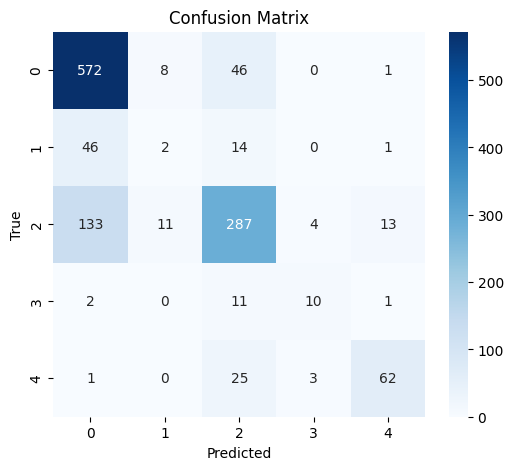

In [8]:
import os, numpy as np, tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt, seaborn as sns

# ====== Handcrafted features (đủ dùng, fallback nếu thiếu skimage/cv2) ======
try:
    import cv2
except Exception:
    cv2 = None
try:
    from skimage.feature import greycomatrix, greycoprops, local_binary_pattern
except Exception:
    greycomatrix = greycoprops = local_binary_pattern = None

def _rgb_hsv_stats(img_u8):
    means = img_u8.reshape(-1,3).mean(axis=0)
    stds  = img_u8.reshape(-1,3).std(axis=0) + 1e-6
    if cv2 is not None:
        hsv = cv2.cvtColor(img_u8, cv2.COLOR_RGB2HSV)
        means_hsv = hsv.reshape(-1,3).mean(axis=0)
        stds_hsv  = hsv.reshape(-1,3).std(axis=0) + 1e-6
    else:
        means_hsv = np.zeros(3); stds_hsv = np.zeros(3)
    return np.concatenate([means, stds, means_hsv, stds_hsv], 0).astype(np.float32)  # 12

def _green_hist(img_u8, bins=16):
    g = img_u8[:,:,1]
    hist, _ = np.histogram(g, bins=bins, range=(0,255), density=True)
    return hist.astype(np.float32)  # 16

def _to_gray(img_u8):
    if cv2 is not None:
        return cv2.cvtColor(img_u8, cv2.COLOR_RGB2GRAY)
    # fallback RGB->Gray
    gray = 0.2989*img_u8[:,:,0] + 0.5870*img_u8[:,:,1] + 0.1140*img_u8[:,:,2]
    return np.clip(gray, 0, 255).astype(np.uint8)

def _glcm_feats(img_u8, levels=32):
    if greycomatrix is None or greycoprops is None:
        return np.zeros(6, dtype=np.float32)
    gray = _to_gray(img_u8)
    q = (gray.astype(np.float32) * (levels/256.0)).astype(np.uint8)
    dists = [1,2,4]; angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = greycomatrix(q, distances=dists, angles=angles, levels=levels, symmetric=True, normed=True)
    feats = []
    for prop in ['contrast','dissimilarity','homogeneity','energy','correlation','ASM']:
        feats.append(greycoprops(glcm, prop).mean())
    return np.array(feats, dtype=np.float32)  # 6

def _lbp_hist(img_u8, P=8, R=1.0):
    if local_binary_pattern is None:
        return np.zeros(P+2, dtype=np.float32)
    gray = _to_gray(img_u8)
    lbp = local_binary_pattern(gray, P=P, R=R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P+3), range=(0, P+2), density=True)
    return hist.astype(np.float32)  # 10

def handcrafted_features_numpy(img_np_uint8):
    # img_np_uint8: (H,W,3) uint8 [0..255]
    f1 = _rgb_hsv_stats(img_np_uint8)         # 12
    f2 = _green_hist(img_np_uint8, 16)        # 16
    f3 = _glcm_feats(img_np_uint8, 32)        # 6
    f4 = _lbp_hist(img_np_uint8, 8, 1.0)      # 10
    return np.concatenate([f1,f2,f3,f4], 0).astype(np.float32)  # 44 dims

# ====== EVALUATE (robust, không dùng map để gắn feature) ======
def evaluate_model_on_test(model_path, test_dir, img_size=224, batch_size=16, labels=("0","1","2","3","4")):
    model = keras.models.load_model(model_path, compile=False, safe_mode=False)
    want_two_inputs = (len(model.inputs) == 2)

    ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        labels="inferred",
        label_mode="int",
        class_names=list(labels),
        color_mode="rgb",
        image_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=False
    )

    X_img_list, X_feat_list, y_list = [], [], []
    for x_batch, y_batch in ds:  # x_batch float32 [0..255] (do Keras loader)
        x_np = x_batch.numpy().astype(np.float32)  # giữ [0..255], không chia 255 nếu model có Rescaling bên trong
        y_np = y_batch.numpy().astype(np.int32)
        y_list.append(y_np)

        if want_two_inputs:
            # Tính feature thủ công trên phiên bản uint8
            x_u8 = np.clip(x_np, 0, 255).astype(np.uint8)
            feats = np.stack([handcrafted_features_numpy(img) for img in x_u8], axis=0)  # (B, F)
            X_feat_list.append(feats)

        X_img_list.append(x_np)

    X_img = np.concatenate(X_img_list, axis=0)
    y_true = np.concatenate(y_list, axis=0)
    if want_two_inputs:
        X_feat = np.concatenate(X_feat_list, axis=0)

    # Dự đoán: truyền list [X_img, X_feat] nếu model 2-input
    if want_two_inputs:
        y_prob = model.predict([X_img, X_feat], verbose=1)
    else:
        y_prob = model.predict(X_img, verbose=1)

    y_pred = np.argmax(y_prob, axis=1) if y_prob.ndim > 1 else (y_prob > 0.5).astype("int32")

    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, digits=4, target_names=list(labels)))
    acc = accuracy_score(y_true, y_pred); print(f"Overall Accuracy: {acc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(labels), yticklabels=list(labels))
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
    plt.show()


# ====== RUN ======
if __name__ == "__main__":
    TEST_DIR = r"D:\Diux\hoctap\DoAn\ddr\test_preprocess"
    evaluate_model_on_test(
        model_path=r"D:\Diux\hoctap\DoAn\models\outputs_msedensenet\finetune_best.keras",
        test_dir=TEST_DIR, img_size=224, batch_size=16
    )
